In [1]:
%load_ext autoreload
%autoreload 2

In [155]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.io

In [6]:
from src.OED import *
from src.DQN import DQNConfig, DQN_OED
from src.GA import *
from pde.AdvectionEquation import *

## Evaluating models

In [14]:
pde_system = Advection2D(Adv2dModelConfig())
# gym_config = OEDGymConfig()
# gym_config.n_sensor = 2
# gym_config.n_components_rewards = 0.99

In [15]:
# dqn_config = DQNConfig()

### Old action space model : Seed 1, run 17

In [100]:
seed = 1
run_num = 17
model_name = f'trained_model/Adv_old/Advection2D_old_dqn_{run_num}_seed_{seed}.zip'
config_path = f'trained_model/Adv_old/Advection2D_old_dqn_{run_num}_seed_{seed}_config.pt'

In [101]:
configs = torch.load(config_path, weights_only=False)

# Access individual configs
gym_config = configs["gym_config"]
dqn_config = configs["dqn_config"]
tensorboard_dir = configs["tensorboard_log"]

In [102]:
gym_config.old_action_space = True
dqn_old = DQN_OED(seed, pde_system, gym_config, dqn_config, verbose=1)
dqn_old.load(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [103]:
old_a_all_ep_rewards, old_a_best_rewards, old_a_optimal_states_all = dqn_old.evaluate(50)

100%|██████████| 50/50 [00:00<00:00, 50.28it/s]


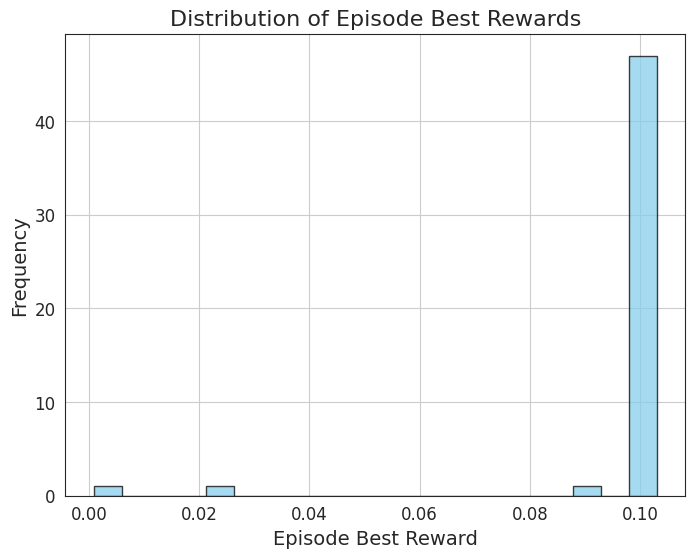

In [104]:
plt.figure(figsize=(8, 6))
plt.hist(old_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Best Rewards')
plt.grid(True)
plt.show()

## New Action space

In [105]:
seed = 1
run_num = 1
model_name = f'trained_model/Advection2D_new_dqn_{run_num}_seed_{seed}.zip'
config_path = f'trained_model/Advection2D_new_dqn_{run_num}_seed_{seed}_config.pt'

In [107]:
configs = torch.load(config_path, weights_only=False)

# Access individual configs
gym_config = configs["gym_config"]
dqn_config = configs["dqn_config"]
tensorboard_dir = configs["tensorboard_log"]

In [108]:
tensorboard_dir

'./tensorboard/DQN_1'

In [109]:
gym_config.old_action_space = False
dqn_new = DQN_OED(seed, pde_system, gym_config, dqn_config, verbose=1)
dqn_new.load(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [110]:
new_a_all_ep_rewards, new_a_best_rewards, new_a_optimal_states_all = dqn_new.evaluate(num_episodes=20)

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


## GA

In [180]:
ga_filename = "GAResults/Advection2D_ga_3.mat"

In [181]:
ga_res = scipy.io.loadmat(ga_filename)

## Plots

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LightSource

In [116]:
env = dqn_old.env

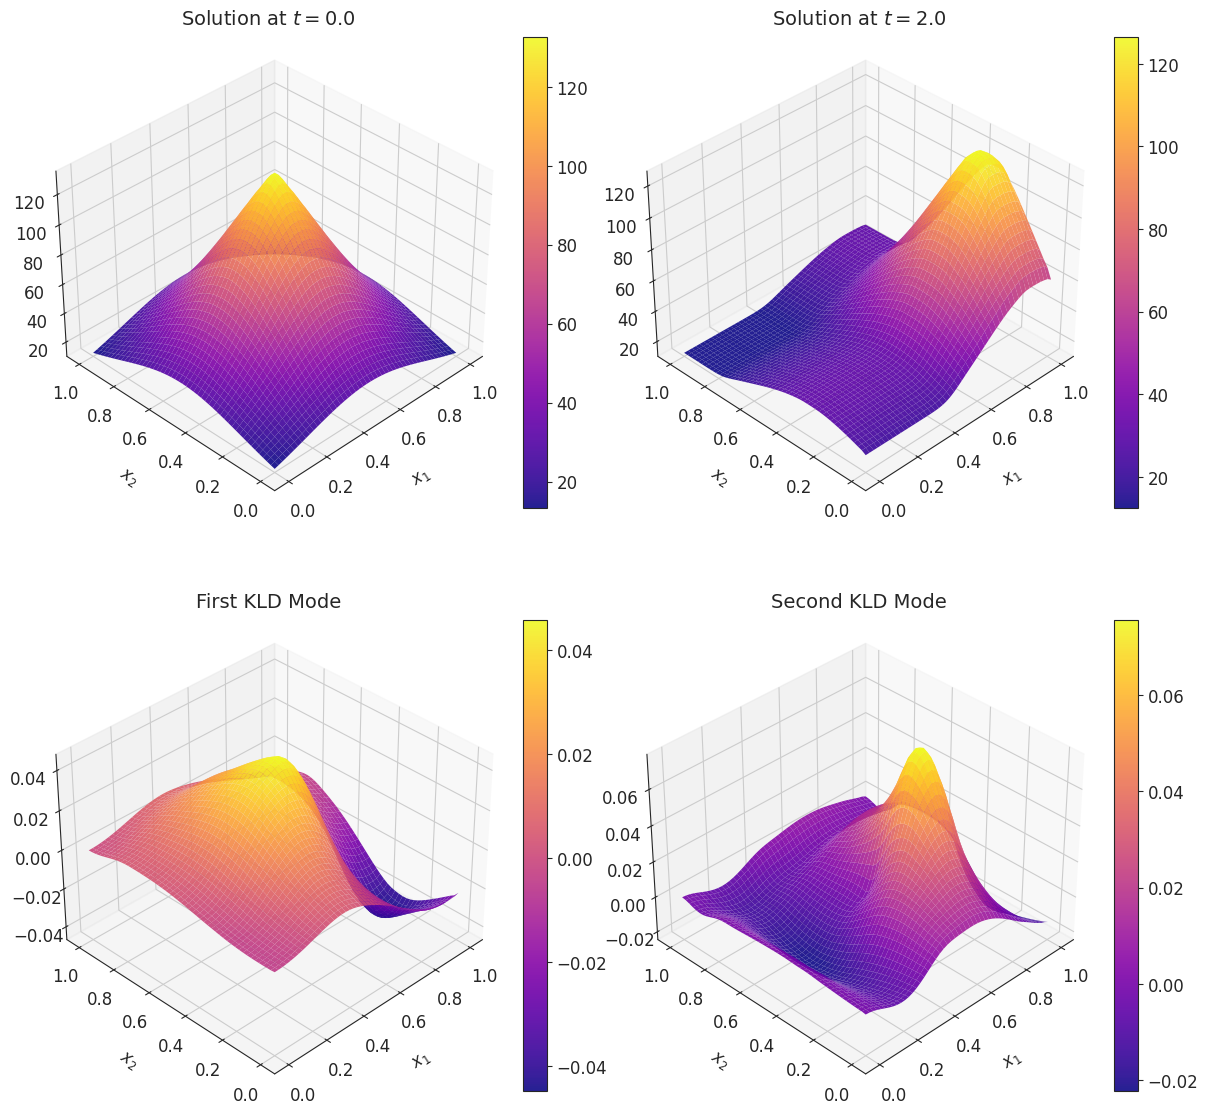

In [121]:
## Solution and Modes

fig = plt.figure(figsize=(12, 12)) 

x = np.linspace(0, 1, env.nx)
y = np.linspace(0, 1, env.ny)
X, Y = np.meshgrid(x, y)

datasets = [
    (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
    (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
    (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
    (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
]

for i, (data, title) in enumerate(datasets):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    
    ls = LightSource(azdeg=315, altdeg=-65)
    shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

    surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)
    
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
    ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
    # ax.set_zlabel(r'$u(x_1, x_2)$', fontsize=12, labelpad=10)

    ax.view_init(elev=35, azim=-135)

    fig.colorbar(surf, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("3D_Adv2d_2x2.pdf", dpi=400, bbox_inches='tight')


plt.show()


In [122]:
# Old DQN: Training and reward

In [128]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd

In [145]:
# log_dir = 'trained_model/Adv_old/DQN_20/'
# tags = ['rollout/ep_rew_mean', 'train/loss']

# # Load the TensorBoard data
# ea = event_accumulator.EventAccumulator(
#     log_dir,
#     size_guidance={
#         event_accumulator.SCALARS: 0,
#     }
# )
# ea.Reload()

# available_tags = ea.Tags()['scalars']

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# data_rew_mean = ea.Scalars('rollout/ep_rew_mean')
# df_rew_mean = pd.DataFrame(data_rew_mean)

# ax1.plot(df_rew_mean.step, df_rew_mean.value, label='rollout/ep_rew_mean', color='blue')
# ax1.set_title('Rollout Episode Reward Mean')
# # ax1.set_xlabel('Step')
# ax1.set_ylabel('Reward')
# ax1.legend()

# data_loss = ea.Scalars('train/loss')
# df_loss = pd.DataFrame(data_loss)

# ax2.plot(df_loss.step, df_loss.value, label='train/loss', color='orange')
# ax2.set_title('Training Loss')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')
# ax2.set_yscale('log')
# ax2.legend()

# plt.tight_layout()
# # plt.savefig("old_dqn_adv2d.pdf", dpi=400, bbox_inches='tight')
# plt.show()

In [141]:
# New DQN: Training and reward

In [146]:
# log_dir = 'trained_model/Adv_new/DQN_1/'
# tags = ['rollout/ep_rew_mean', 'train/loss']

# # Load the TensorBoard data
# ea = event_accumulator.EventAccumulator(
#     log_dir,
#     size_guidance={
#         event_accumulator.SCALARS: 0,
#     }
# )
# ea.Reload()

# available_tags = ea.Tags()['scalars']

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# data_rew_mean = ea.Scalars('rollout/ep_rew_mean')
# df_rew_mean = pd.DataFrame(data_rew_mean)

# ax1.plot(df_rew_mean.step, df_rew_mean.value, label='rollout/ep_rew_mean', color='blue')
# ax1.set_title('Rollout Episode Reward Mean')
# # ax1.set_xlabel('Step')
# ax1.set_ylabel('Reward')
# ax1.legend()

# data_loss = ea.Scalars('train/loss')
# df_loss = pd.DataFrame(data_loss)

# ax2.plot(df_loss.step, df_loss.value, label='train/loss', color='orange')
# ax2.set_title('Training Loss')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')
# ax2.set_yscale('log')
# ax2.legend()

# plt.tight_layout()
# # plt.savefig("new_dqn_adv2d.pdf", dpi=400, bbox_inches='tight')
# plt.show()

In [147]:
# Reward distribution comparison

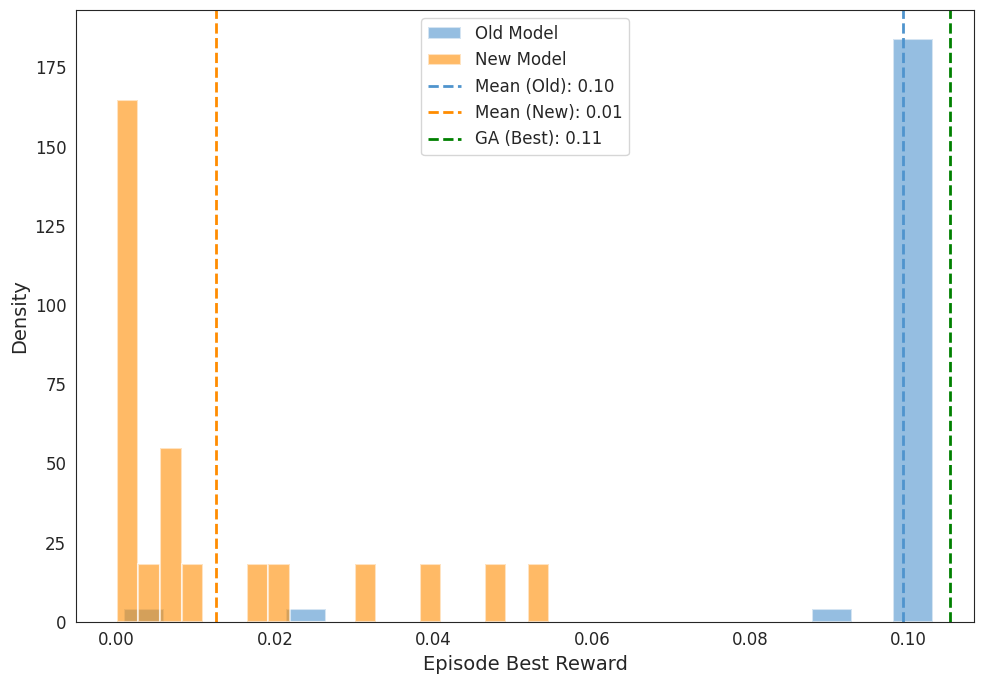

In [184]:
plt.figure(figsize=(10, 7))
plt.hist(old_a_best_rewards, bins=20, 
         color='#4F94CD',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='Old Model')

plt.hist(new_a_best_rewards, bins=20, 
         color='#FF8C00',
         edgecolor='white', 
         linewidth=1.5, 
         alpha=0.6, 
         density=True,  # Normalize densities
         label='New Model')

mean_old = np.mean(old_a_best_rewards)
mean_new = np.mean(new_a_best_rewards)
ga_best = ga_res['best_fitness'][0][0]

plt.axvline(x=mean_old, color='#4F94CD', linestyle='--', linewidth=2, label=f'Mean (Old): {mean_old:.2f}')
plt.axvline(x=mean_new, color='#FF8C00', linestyle='--', linewidth=2, label=f'Mean (New): {mean_new:.2f}')
plt.axvline(x=ga_best, color='g', linestyle='--', linewidth=2, label=f'GA (Best): {ga_best:.2f}')

plt.xlabel('Episode Best Reward', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("adv2d_res_hist.pdf", dpi=400, bbox_inches='tight')
plt.show()

In [63]:
# import numpy as np
# import matplotlib.pyplot as plt
# plt.rcParams.update({
#     'font.family': 'sans-serif',
#     'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
#     'font.size': 12,
#     'axes.titlesize': 16,
#     'axes.labelsize': 14,
# })

# # Compute sum of optimal_states over all episodes
# # Assumes that each info["optimal_states"] is a numpy array of the same shape
# optimal_states_stack = np.array(old_a_optimal_states_all)
# mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# # Create figure with better dimensions
# fig, ax = plt.subplots(figsize=(10, 8))

# # Create a more visually appealing heatmap
# heatmap = ax.imshow(mean_optimal_states, 
#                     cmap='viridis',
#                     interpolation='nearest')

# # Add grid lines to make it easier to read specific cell values
# ax.set_xticks(np.arange(-.5, mean_optimal_states.shape[1], 1), minor=True)
# ax.set_yticks(np.arange(-.5, mean_optimal_states.shape[0], 1), minor=True)
# ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
# ax.tick_params(which="minor", size=0)

# # Improve colorbar appearance
# cbar = fig.colorbar(heatmap, ax=ax, pad=0.01)
# cbar.set_label('Total Placements', fontweight='bold', labelpad=10)
# cbar.ax.tick_params(labelsize=10)

# # Add a more descriptive title with statistics
# max_val = np.max(mean_optimal_states)
# total_placements = np.sum(mean_optimal_states)
# title = f'Optimal States Placement Heatmap\n(Total: {int(total_placements)}, Max: {int(max_val)})'
# ax.set_title(title, fontweight='bold', pad=15)

# # Add text showing the number of episodes
# episodes_text = f'Based on data from {optimal_states_stack.shape[0]} episodes'
# plt.figtext(0.5, 0.01, episodes_text, ha="center", fontsize=12, fontstyle='italic')

# # Tight layout for better spacing
# plt.tight_layout()

# plt.show()

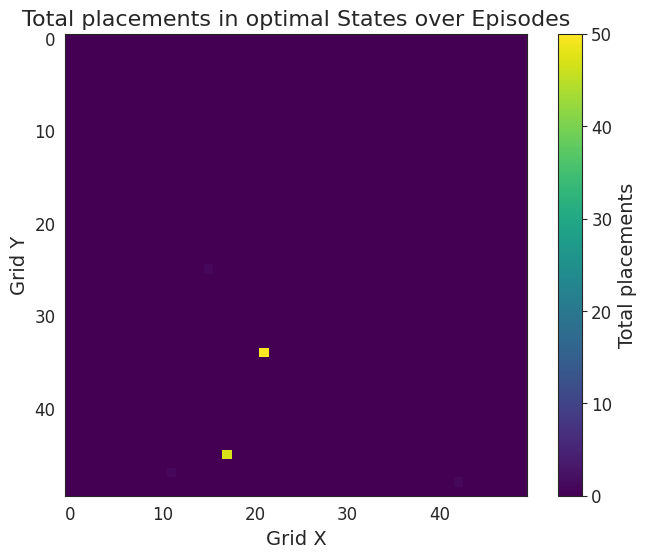

In [81]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
optimal_states_stack = np.array(old_a_optimal_states_all)
mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

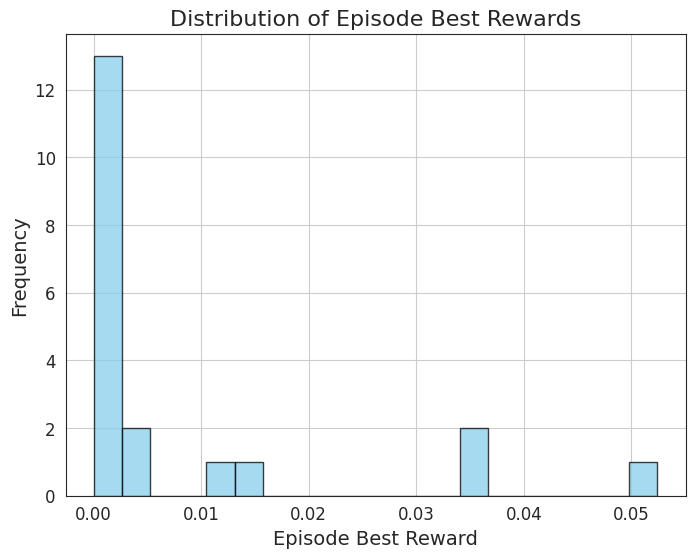

In [82]:
plt.figure(figsize=(8, 6))
plt.hist(new_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Best Rewards')
plt.grid(True)
plt.show()

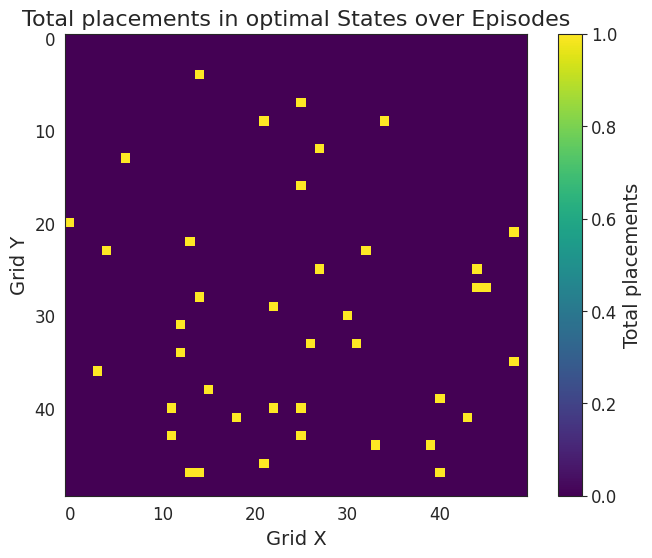

In [83]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
optimal_states_stack = np.array(new_a_optimal_states_all)
mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

In [167]:
adv_config = Adv2dModelConfig()
adv_eq = Advection2D(adv_config)

## DQN

In [15]:
seed = None
gym_config = OEDGymConfig()
gym_config.n_sensor = 2

### Old Action Space

In [16]:
gym_config.old_action_space = True

In [19]:
adv_dqn_old_a = DQN_OED(seed, pde_system=adv_eq, gym_config=gym_config, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
adv_dqn_old_a.env.modes

(2500, 2)

In [11]:
model_name = "adv_dqn_old_a_1"
adv_dqn_old_a.train(model_name, total_timesteps=500, log_interval=10)

Logging to ./tensorboard/DQN_3


In [13]:
log_dir = adv_dqn_old_a.model.logger.dir
print(f"Tensorboard logs are being saved to: {log_dir}")

Tensorboard logs are being saved to: ./tensorboard/DQN_3


In [ ]:
old_a_all_ep_rewards, old_a_best_rewards, old_a_optimal_states_all = adv_dqn_old_a.evaluate(num_episodes=1000)

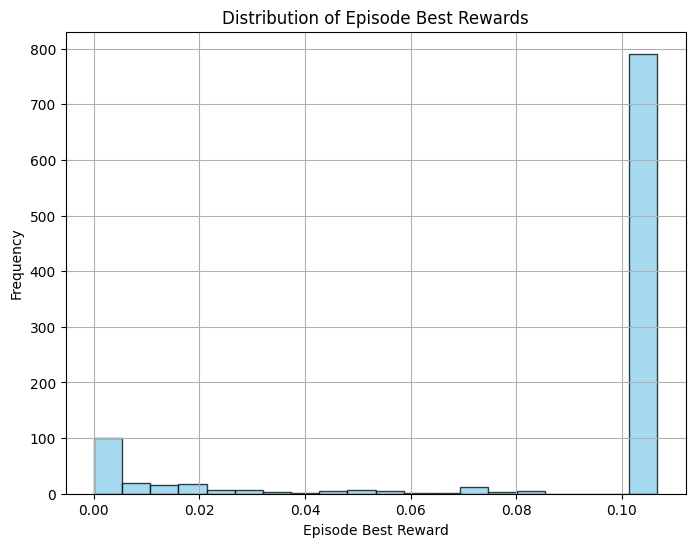

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(old_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Best Rewards')
plt.grid(True)
plt.show()


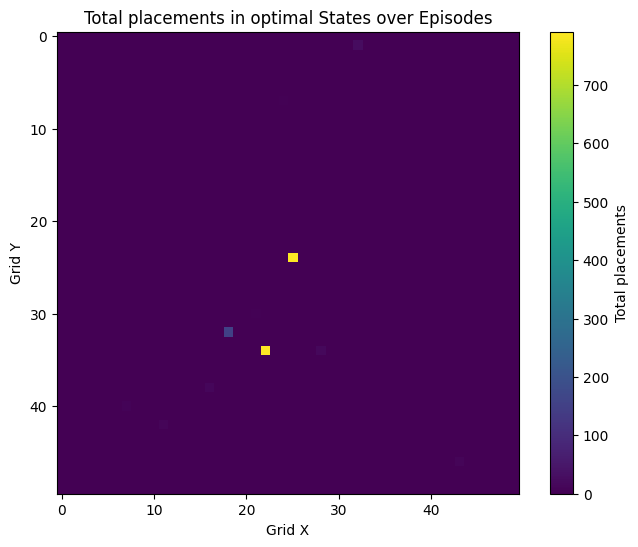

In [15]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
optimal_states_stack = np.array(old_a_optimal_states_all)
mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

In [62]:
np.max(old_a_best_rewards)

np.float64(0.10679207235193365)

### New action space

In [11]:
gym_config.old_action_space = False

In [12]:
adv_dqn_new_a = DQN_OED(seed, pde_system=adv_eq, gym_config=gym_config, verbose=0)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model_name = "adv_dqn_new_a_1"
adv_dqn_new_a.train(model_name, total_timesteps=50000, log_interval=10)

In [64]:
new_a_all_ep_rewards, new_a_best_rewards, new_a_optimal_states_all = adv_dqn_new_a.evaluate(num_episodes=100)

100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


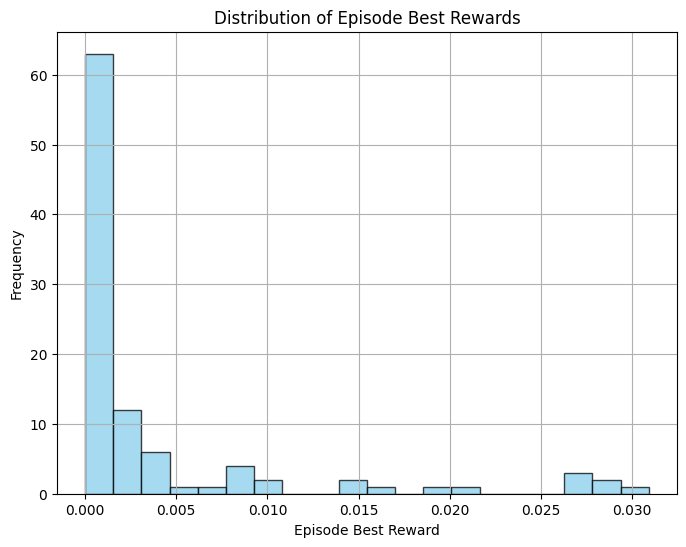

In [66]:
plt.figure(figsize=(8, 6))
plt.hist(new_a_best_rewards, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.xlabel('Episode Best Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Best Rewards')
plt.grid(True)
plt.show()

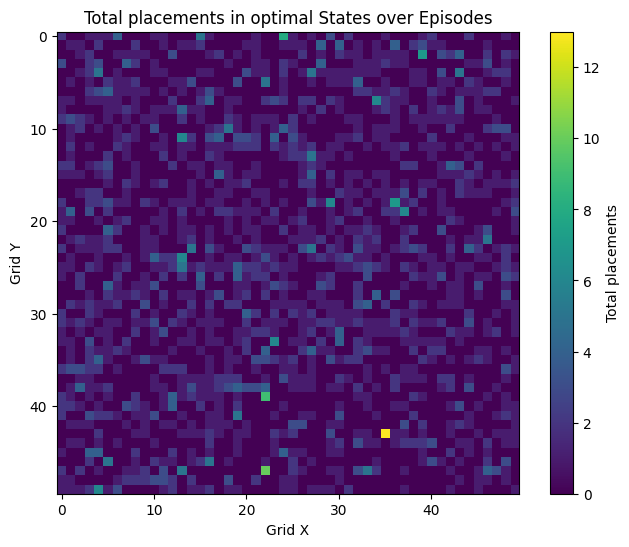

In [17]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
optimal_states_stack = np.array(new_a_optimal_states_all)
mean_optimal_states = np.sum(optimal_states_stack, axis=0)

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

In [65]:
np.max(new_a_best_rewards)

np.float64(0.03090883929171273)

## Using GA

In [164]:
seed = None
gym_config = OEDGymConfig()
gym_config.n_sensor = 2

In [165]:
ga_config = GAConfig()

In [171]:
ga = GA_OED(pde_system=adv_eq, gym_config=gym_config, ga_config=ga_config)

/home/darve/apoorv1/.conda/envs/cs234_a3/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/darve/apoorv1/.conda/envs/cs234_a3/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [172]:
best_individual, best_fitness, sensor_positions, logbook = ga.run()

gen	nevals	avg      	min        	max     
0  	100   	0.0018205	2.92391e-08	0.020517
1  	73    	0.00354006	8.46849e-08	0.0287358
2  	80    	0.00607092	8.60505e-08	0.0409633
3  	78    	0.0108022 	1.30973e-09	0.0482427
4  	78    	0.0160383 	5.31185e-08	0.0605674
5  	81    	0.0225129 	8.60505e-08	0.0605674
6  	72    	0.0305932 	9.5251e-08 	0.0605674
7  	82    	0.0440189 	0.000597533	0.0605674
8  	80    	0.0536018 	7.47414e-06	0.0605674
9  	78    	0.0581714 	4.53631e-05	0.0605674
10 	80    	0.0593354 	0.000573301	0.0605674
11 	92    	0.0587347 	0.000205318	0.0605674
12 	69    	0.0578608 	2.44449e-05	0.0605674
13 	74    	0.0599662 	0.000448908	0.0605674
14 	83    	0.0577343 	3.82312e-06	0.0605674
15 	78    	0.0601278 	0.0166062  	0.0605674
16 	73    	0.0594574 	0.00140375 	0.0605674
17 	70    	0.0595771 	0.0103415  	0.0605674
18 	81    	0.0589337 	8.64948e-05	0.0605674
19 	81    	0.0593685 	0.000573724	0.0605674
20 	86    	0.0603083 	0.0346567  	0.0605674
21 	87    	0.0587583 	2.36605e-05	0.

In [21]:
best_individual, best_fitness, sensor_positions, logbook = ga.run()

gen	nevals	avg       	min        	max      
0  	100   	0.00266669	1.02596e-07	0.0976222
1  	78    	0.00831719	2.25317e-06	0.0976222
2  	80    	0.0161903 	9.36286e-06	0.0976222
3  	80    	0.0260693 	1.18124e-06	0.0976222
4  	83    	0.0339141 	1.18124e-06	0.0976222
5  	81    	0.0438702 	1.18124e-06	0.0992315
6  	81    	0.0524401 	1.81425e-07	0.0992315
7  	87    	0.0563477 	1.79044e-05	0.0992315
8  	78    	0.0680488 	0.00025647 	0.0992315
9  	72    	0.0841957 	2.96454e-06	0.0992315
10 	81    	0.0956517 	3.23746e-06	0.0992315
11 	86    	0.0989901 	0.0976222  	0.0992315
12 	81    	0.0978627 	0.00334163 	0.0992315
13 	79    	0.0974466 	0.00113094 	0.0992315
14 	83    	0.0973125 	0.000555242	0.0992315
15 	77    	0.0955535 	0.000236494	0.0992315
16 	81    	0.0953197 	1.76054e-05	0.0992315
17 	84    	0.0956857 	3.70897e-05	0.0992315
18 	75    	0.0992315 	0.0992315  	0.0992315
19 	78    	0.0967395 	1.35852e-06	0.0992315
20 	82    	0.0962624 	1.41841e-05	0.0992315
21 	81    	0.0948266 	5.68701e-0

In [28]:
print(f"Best fitness: {best_fitness}")
print(f"Sensor positions: {sensor_positions}")

Best fitness: 0.09923148696955546
Sensor positions: [(37, 19), (46, 14)]


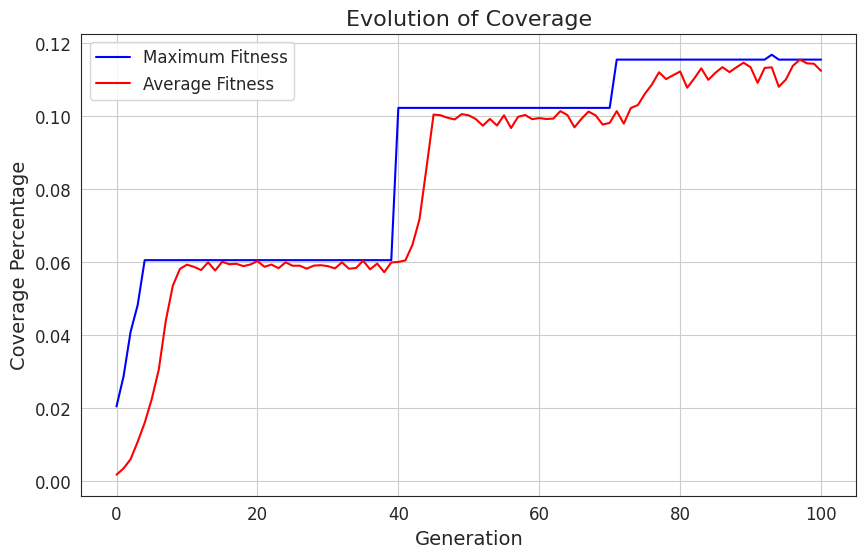

In [173]:
# Visualize the solution
# ga.visualize_solution(sensor_positions)

# Plot evolution progress
gen = logbook.select("gen")
fit_max = logbook.select("max")
fit_avg = logbook.select("avg")

plt.figure(figsize=(10, 6))
plt.plot(gen, fit_max, 'b-', label='Maximum Fitness')
plt.plot(gen, fit_avg, 'r-', label='Average Fitness')
plt.title('Evolution of Coverage')
plt.xlabel('Generation')
plt.ylabel('Coverage Percentage')
plt.legend()
plt.grid(True)
plt.show()

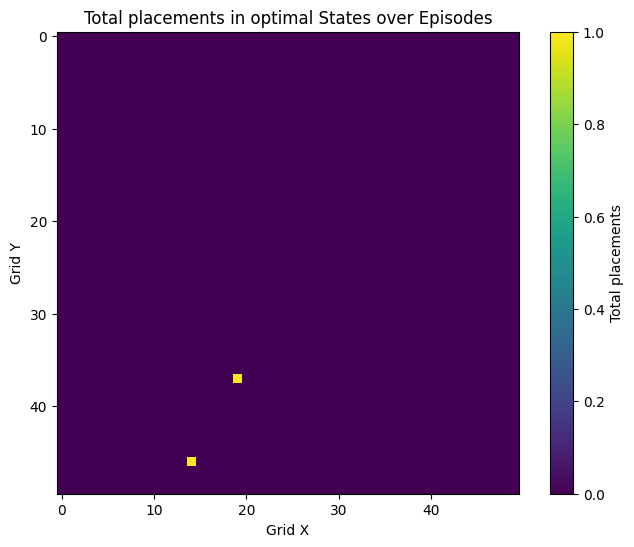

In [27]:
# Compute sum of optimal_states over all episodes
# Assumes that each info["optimal_states"] is a numpy array of the same shape
mean_optimal_states =np.zeros((ga.env.nx, ga.env.ny))
mean_optimal_states[37, 19] = 1
mean_optimal_states[46, 14] = 1

# Plot grid of mean optimal_states
plt.figure(figsize=(8, 6))
plt.imshow(mean_optimal_states, cmap='viridis', interpolation='nearest')
plt.title('Total placements in optimal States over Episodes')
plt.colorbar(label='Total placements')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()

## Plots

In [32]:
env = adv_dqn_old_a.env

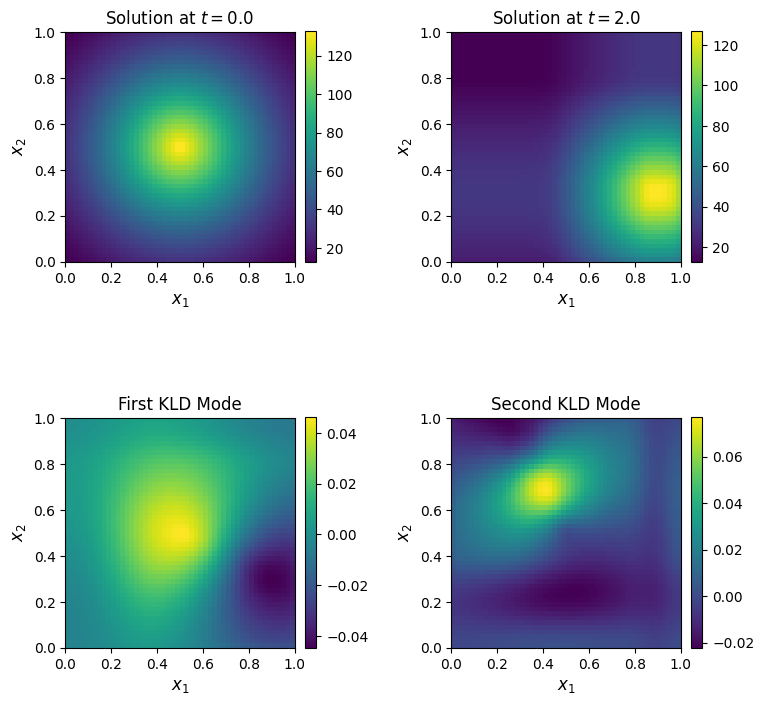

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

im1 = axes[0, 0].imshow(env.pde_field[:, :, 0].T, origin='lower', extent=[0, 1, 0, 1])
axes[0, 0].set_title(rf"Solution at $t = {adv_dqn_old_a.env.pde_system.t_steps[0]}$", fontsize=12)
axes[0, 0].set_xlabel(r'$x_1$', fontsize=12)
axes[0, 0].set_ylabel(r'$x_2$', fontsize=12)
cbar1 = fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)

# Second subplot
im2 = axes[0, 1].imshow(env.pde_field[:, :, -1].T, origin='lower', extent=[0, 1, 0, 1])
axes[0, 1].set_title(rf"Solution at $t = {adv_dqn_old_a.env.pde_system.t_steps[-1]}$", fontsize=12)
axes[0, 1].set_xlabel(r'$x_1$', fontsize=12)
axes[0, 1].set_ylabel(r'$x_2$', fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)

# Third subplot
im3 = axes[1, 0].imshow(env.modes[:, 0].reshape(env.nx, env.ny).T, origin='lower', extent=[0, 1, 0, 1])
axes[1, 0].set_title(rf"First KLD Mode", fontsize=12)
axes[1, 0].set_xlabel(r'$x_1$', fontsize=12)
axes[1, 0].set_ylabel(r'$x_2$', fontsize=12)
cbar3 = fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
cbar3.ax.tick_params(labelsize=10)

# Fourth subplot
im4 = axes[1, 1].imshow(env.modes[:, 1].reshape(env.nx, env.ny), origin='lower', extent=[0, 1, 0, 1])
axes[1, 1].set_title(rf"Second KLD Mode", fontsize=12)
axes[1, 1].set_xlabel(r'$x_1$', fontsize=12)
axes[1, 1].set_ylabel(r'$x_2$', fontsize=12)
cbar4 = fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=10)

# Adjust layout to avoid overlap
plt.tight_layout(pad=2)
# plt.savefig("IB2dSol.pdf", dpi=400)

# Show the plot
plt.show()


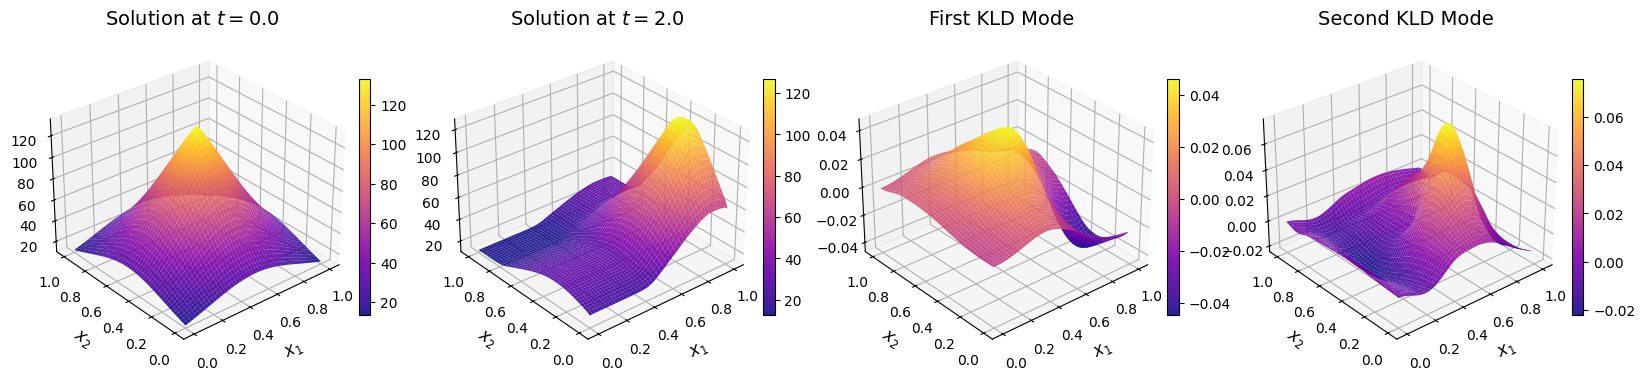

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LightSource

# Create a 1x4 grid of 3D subplots
fig = plt.figure(figsize=(20, 6))  # Wider figure for 1x4 layout

# Generate grid points
x = np.linspace(0, 1, env.nx)
y = np.linspace(0, 1, env.ny)
X, Y = np.meshgrid(x, y)

# Define the plots
datasets = [
    (env.pde_field[:, :, 0].T, rf"Solution at $t = {env.pde_system.t_steps[0]}$"),
    (env.pde_field[:, :, -1].T, rf"Solution at $t = {env.pde_system.t_steps[-1]}$"),
    (env.modes[:, 0].reshape(env.nx, env.ny).T, "First KLD Mode"),
    (env.modes[:, 1].reshape(env.nx, env.ny).T, "Second KLD Mode")
]

# Create 3D subplots in a single row
for i, (data, title) in enumerate(datasets):
    ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    
    # Compute shading effect
    ls = LightSource(azdeg=315, altdeg=65)
    shaded = ls.shade(data, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')

    # Create surface plot
    surf = ax.plot_surface(X, Y, data, cmap='plasma', edgecolor='none', alpha=0.9)
    
    # Set titles and labels
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=5)
    ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=5)
    
    # Adjust viewing angle
    ax.view_init(elev=30, azim=-130)

    # Add colorbar (adjusted for compact layout)
    fig.colorbar(surf, ax=ax, fraction=0.035, pad=0.02)

# Save and display
plt.savefig("3D_Adv2d_modes.pdf", dpi=400, bbox_inches='tight')
plt.show()


In [70]:
print(f"{np.max(old_a_best_rewards):.3e}, {np.max(new_a_best_rewards):.3e}, {best_fitness:.3e}, {np.mean(old_a_best_rewards):.3e}, {np.mean(new_a_best_rewards):.3e}")

1.068e-01, 3.091e-02, 9.923e-02, 8.818e-02, 3.948e-03
